In [2]:
from keras.models import Sequential, load_model
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil
%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
model = custom_unet(input_shape=(512,512,1), num_classes=2)
model.load_weights('UNET_KU_EM_UB_train_MA_val.h5')

In [5]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_K' in f:
        continue
      else:
        images.append(f)
        #segmentations.append(f.replace('.nii', '_K.nii'))

    #print(images[0], segmentations[0])
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [9]:
data_path = r'C:\Users\UAB\data\Emory\data'
images = gather_images(data_path)

In [10]:
print(images[0])
print(len(images))
print(images[0:2])

EM_200922_0_144_L_0_M.npy
18974
['EM_200922_0_144_L_0_M.npy' 'EM_200922_0_144_L_100_M.npy']


In [11]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

We need to gather a stack of 32 images for the prediction in the shape (32, 512, 512, 1)


In [28]:
#divide the number of images avaliable into batches of 32, then we can feed it a batch at a time and 
# then we can append to the larger stack



label_list = []
predictions = []
data_path = r"C:\Users\UAB\data\Emory\data"
pred_path = r"C:\Users\UAB\data\Emory\Predictions\KU_EM_UB-MA"
images = gather_images(data_path)

batches = len(images)//32
left_over = len(images)%32 
print(batches, left_over)


#REMEMBER TO COME BACK FOR LEFTOVERS
for i in range(batches):
    image_stack = np.empty((32,512,512,1))
    for x in range(32*i, (32*(i+1))):
        image = np.load(data_path +"\\"+images[x])
        y = x-(32*i)
        #print(x, y)
        image_stack[y, ...,0] = image[...]
        label_match = str(images[x][:-5] + 'K.npy')
        #print(label_match)
        label_list.append(label_match)
        
    img_prediction = model.predict(image_stack)
    img_prediction = img_prediction.astype('float')
    print(img_prediction.shape)
    for z in range(len(img_prediction)):
        print('saving images')
        img_numb = z + 32*i
        print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_list[img_numb][:-5]
        filename = str(label + 'P.npy')
        np.save(os.path.join(pred_path, filename), image_save)  


592 30
(32, 512, 512, 2)
saving images
0 0
saving images
1 1
saving images
2 2
saving images
3 3
saving images
4 4
saving images
5 5
saving images
6 6
saving images
7 7
saving images
8 8
saving images
9 9
saving images
10 10
saving images
11 11
saving images
12 12
saving images
13 13
saving images
14 14
saving images
15 15
saving images
16 16
saving images
17 17
saving images
18 18
saving images
19 19
saving images
20 20
saving images
21 21
saving images
22 22
saving images
23 23
saving images
24 24
saving images
25 25
saving images
26 26
saving images
27 27
saving images
28 28
saving images
29 29
saving images
30 30
saving images
31 31
(32, 512, 512, 2)
saving images
0 32
saving images
1 33
saving images
2 34
saving images
3 35
saving images
4 36
saving images
5 37
saving images
6 38
saving images
7 39
saving images
8 40
saving images
9 41
saving images
10 42
saving images
11 43
saving images
12 44
saving images
13 45
saving images
14 46
saving images
15 47
saving images
16 48
saving 

(32, 512, 512, 2)
saving images
0 416
saving images
1 417
saving images
2 418
saving images
3 419
saving images
4 420
saving images
5 421
saving images
6 422
saving images
7 423
saving images
8 424
saving images
9 425
saving images
10 426
saving images
11 427
saving images
12 428
saving images
13 429
saving images
14 430
saving images
15 431
saving images
16 432
saving images
17 433
saving images
18 434
saving images
19 435
saving images
20 436
saving images
21 437
saving images
22 438
saving images
23 439
saving images
24 440
saving images
25 441
saving images
26 442
saving images
27 443
saving images
28 444
saving images
29 445
saving images
30 446
saving images
31 447
(32, 512, 512, 2)
saving images
0 448
saving images
1 449
saving images
2 450
saving images
3 451
saving images
4 452
saving images
5 453
saving images
6 454
saving images
7 455
saving images
8 456
saving images
9 457
saving images
10 458
saving images
11 459
saving images
12 460
saving images
13 461
saving images
14 4

(32, 512, 512, 2)
saving images
0 832
saving images
1 833
saving images
2 834
saving images
3 835
saving images
4 836
saving images
5 837
saving images
6 838
saving images
7 839
saving images
8 840
saving images
9 841
saving images
10 842
saving images
11 843
saving images
12 844
saving images
13 845
saving images
14 846
saving images
15 847
saving images
16 848
saving images
17 849
saving images
18 850
saving images
19 851
saving images
20 852
saving images
21 853
saving images
22 854
saving images
23 855
saving images
24 856
saving images
25 857
saving images
26 858
saving images
27 859
saving images
28 860
saving images
29 861
saving images
30 862
saving images
31 863
(32, 512, 512, 2)
saving images
0 864
saving images
1 865
saving images
2 866
saving images
3 867
saving images
4 868
saving images
5 869
saving images
6 870
saving images
7 871
saving images
8 872
saving images
9 873
saving images
10 874
saving images
11 875
saving images
12 876
saving images
13 877
saving images
14 8

(32, 512, 512, 2)
saving images
0 1216
saving images
1 1217
saving images
2 1218
saving images
3 1219
saving images
4 1220
saving images
5 1221
saving images
6 1222
saving images
7 1223
saving images
8 1224
saving images
9 1225
saving images
10 1226
saving images
11 1227
saving images
12 1228
saving images
13 1229
saving images
14 1230
saving images
15 1231
saving images
16 1232
saving images
17 1233
saving images
18 1234
saving images
19 1235
saving images
20 1236
saving images
21 1237
saving images
22 1238
saving images
23 1239
saving images
24 1240
saving images
25 1241
saving images
26 1242
saving images
27 1243
saving images
28 1244
saving images
29 1245
saving images
30 1246
saving images
31 1247
(32, 512, 512, 2)
saving images
0 1248
saving images
1 1249
saving images
2 1250
saving images
3 1251
saving images
4 1252
saving images
5 1253
saving images
6 1254
saving images
7 1255
saving images
8 1256
saving images
9 1257
saving images
10 1258
saving images
11 1259
saving images
12

(32, 512, 512, 2)
saving images
0 1600
saving images
1 1601
saving images
2 1602
saving images
3 1603
saving images
4 1604
saving images
5 1605
saving images
6 1606
saving images
7 1607
saving images
8 1608
saving images
9 1609
saving images
10 1610
saving images
11 1611
saving images
12 1612
saving images
13 1613
saving images
14 1614
saving images
15 1615
saving images
16 1616
saving images
17 1617
saving images
18 1618
saving images
19 1619
saving images
20 1620
saving images
21 1621
saving images
22 1622
saving images
23 1623
saving images
24 1624
saving images
25 1625
saving images
26 1626
saving images
27 1627
saving images
28 1628
saving images
29 1629
saving images
30 1630
saving images
31 1631
(32, 512, 512, 2)
saving images
0 1632
saving images
1 1633
saving images
2 1634
saving images
3 1635
saving images
4 1636
saving images
5 1637
saving images
6 1638
saving images
7 1639
saving images
8 1640
saving images
9 1641
saving images
10 1642
saving images
11 1643
saving images
12

(32, 512, 512, 2)
saving images
0 1984
saving images
1 1985
saving images
2 1986
saving images
3 1987
saving images
4 1988
saving images
5 1989
saving images
6 1990
saving images
7 1991
saving images
8 1992
saving images
9 1993
saving images
10 1994
saving images
11 1995
saving images
12 1996
saving images
13 1997
saving images
14 1998
saving images
15 1999
saving images
16 2000
saving images
17 2001
saving images
18 2002
saving images
19 2003
saving images
20 2004
saving images
21 2005
saving images
22 2006
saving images
23 2007
saving images
24 2008
saving images
25 2009
saving images
26 2010
saving images
27 2011
saving images
28 2012
saving images
29 2013
saving images
30 2014
saving images
31 2015
(32, 512, 512, 2)
saving images
0 2016
saving images
1 2017
saving images
2 2018
saving images
3 2019
saving images
4 2020
saving images
5 2021
saving images
6 2022
saving images
7 2023
saving images
8 2024
saving images
9 2025
saving images
10 2026
saving images
11 2027
saving images
12

(32, 512, 512, 2)
saving images
0 2368
saving images
1 2369
saving images
2 2370
saving images
3 2371
saving images
4 2372
saving images
5 2373
saving images
6 2374
saving images
7 2375
saving images
8 2376
saving images
9 2377
saving images
10 2378
saving images
11 2379
saving images
12 2380
saving images
13 2381
saving images
14 2382
saving images
15 2383
saving images
16 2384
saving images
17 2385
saving images
18 2386
saving images
19 2387
saving images
20 2388
saving images
21 2389
saving images
22 2390
saving images
23 2391
saving images
24 2392
saving images
25 2393
saving images
26 2394
saving images
27 2395
saving images
28 2396
saving images
29 2397
saving images
30 2398
saving images
31 2399
(32, 512, 512, 2)
saving images
0 2400
saving images
1 2401
saving images
2 2402
saving images
3 2403
saving images
4 2404
saving images
5 2405
saving images
6 2406
saving images
7 2407
saving images
8 2408
saving images
9 2409
saving images
10 2410
saving images
11 2411
saving images
12

saving images
22 2742
saving images
23 2743
saving images
24 2744
saving images
25 2745
saving images
26 2746
saving images
27 2747
saving images
28 2748
saving images
29 2749
saving images
30 2750
saving images
31 2751
(32, 512, 512, 2)
saving images
0 2752
saving images
1 2753
saving images
2 2754
saving images
3 2755
saving images
4 2756
saving images
5 2757
saving images
6 2758
saving images
7 2759
saving images
8 2760
saving images
9 2761
saving images
10 2762
saving images
11 2763
saving images
12 2764
saving images
13 2765
saving images
14 2766
saving images
15 2767
saving images
16 2768
saving images
17 2769
saving images
18 2770
saving images
19 2771
saving images
20 2772
saving images
21 2773
saving images
22 2774
saving images
23 2775
saving images
24 2776
saving images
25 2777
saving images
26 2778
saving images
27 2779
saving images
28 2780
saving images
29 2781
saving images
30 2782
saving images
31 2783
(32, 512, 512, 2)
saving images
0 2784
saving images
1 2785
saving i

(32, 512, 512, 2)
saving images
0 3136
saving images
1 3137
saving images
2 3138
saving images
3 3139
saving images
4 3140
saving images
5 3141
saving images
6 3142
saving images
7 3143
saving images
8 3144
saving images
9 3145
saving images
10 3146
saving images
11 3147
saving images
12 3148
saving images
13 3149
saving images
14 3150
saving images
15 3151
saving images
16 3152
saving images
17 3153
saving images
18 3154
saving images
19 3155
saving images
20 3156
saving images
21 3157
saving images
22 3158
saving images
23 3159
saving images
24 3160
saving images
25 3161
saving images
26 3162
saving images
27 3163
saving images
28 3164
saving images
29 3165
saving images
30 3166
saving images
31 3167
(32, 512, 512, 2)
saving images
0 3168
saving images
1 3169
saving images
2 3170
saving images
3 3171
saving images
4 3172
saving images
5 3173
saving images
6 3174
saving images
7 3175
saving images
8 3176
saving images
9 3177
saving images
10 3178
saving images
11 3179
saving images
12

(32, 512, 512, 2)
saving images
0 3520
saving images
1 3521
saving images
2 3522
saving images
3 3523
saving images
4 3524
saving images
5 3525
saving images
6 3526
saving images
7 3527
saving images
8 3528
saving images
9 3529
saving images
10 3530
saving images
11 3531
saving images
12 3532
saving images
13 3533
saving images
14 3534
saving images
15 3535
saving images
16 3536
saving images
17 3537
saving images
18 3538
saving images
19 3539
saving images
20 3540
saving images
21 3541
saving images
22 3542
saving images
23 3543
saving images
24 3544
saving images
25 3545
saving images
26 3546
saving images
27 3547
saving images
28 3548
saving images
29 3549
saving images
30 3550
saving images
31 3551
(32, 512, 512, 2)
saving images
0 3552
saving images
1 3553
saving images
2 3554
saving images
3 3555
saving images
4 3556
saving images
5 3557
saving images
6 3558
saving images
7 3559
saving images
8 3560
saving images
9 3561
saving images
10 3562
saving images
11 3563
saving images
12

saving images
25 3897
saving images
26 3898
saving images
27 3899
saving images
28 3900
saving images
29 3901
saving images
30 3902
saving images
31 3903
(32, 512, 512, 2)
saving images
0 3904
saving images
1 3905
saving images
2 3906
saving images
3 3907
saving images
4 3908
saving images
5 3909
saving images
6 3910
saving images
7 3911
saving images
8 3912
saving images
9 3913
saving images
10 3914
saving images
11 3915
saving images
12 3916
saving images
13 3917
saving images
14 3918
saving images
15 3919
saving images
16 3920
saving images
17 3921
saving images
18 3922
saving images
19 3923
saving images
20 3924
saving images
21 3925
saving images
22 3926
saving images
23 3927
saving images
24 3928
saving images
25 3929
saving images
26 3930
saving images
27 3931
saving images
28 3932
saving images
29 3933
saving images
30 3934
saving images
31 3935
(32, 512, 512, 2)
saving images
0 3936
saving images
1 3937
saving images
2 3938
saving images
3 3939
saving images
4 3940
saving imag

(32, 512, 512, 2)
saving images
0 4288
saving images
1 4289
saving images
2 4290
saving images
3 4291
saving images
4 4292
saving images
5 4293
saving images
6 4294
saving images
7 4295
saving images
8 4296
saving images
9 4297
saving images
10 4298
saving images
11 4299
saving images
12 4300
saving images
13 4301
saving images
14 4302
saving images
15 4303
saving images
16 4304
saving images
17 4305
saving images
18 4306
saving images
19 4307
saving images
20 4308
saving images
21 4309
saving images
22 4310
saving images
23 4311
saving images
24 4312
saving images
25 4313
saving images
26 4314
saving images
27 4315
saving images
28 4316
saving images
29 4317
saving images
30 4318
saving images
31 4319
(32, 512, 512, 2)
saving images
0 4320
saving images
1 4321
saving images
2 4322
saving images
3 4323
saving images
4 4324
saving images
5 4325
saving images
6 4326
saving images
7 4327
saving images
8 4328
saving images
9 4329
saving images
10 4330
saving images
11 4331
saving images
12

saving images
25 4665
saving images
26 4666
saving images
27 4667
saving images
28 4668
saving images
29 4669
saving images
30 4670
saving images
31 4671
(32, 512, 512, 2)
saving images
0 4672
saving images
1 4673
saving images
2 4674
saving images
3 4675
saving images
4 4676
saving images
5 4677
saving images
6 4678
saving images
7 4679
saving images
8 4680
saving images
9 4681
saving images
10 4682
saving images
11 4683
saving images
12 4684
saving images
13 4685
saving images
14 4686
saving images
15 4687
saving images
16 4688
saving images
17 4689
saving images
18 4690
saving images
19 4691
saving images
20 4692
saving images
21 4693
saving images
22 4694
saving images
23 4695
saving images
24 4696
saving images
25 4697
saving images
26 4698
saving images
27 4699
saving images
28 4700
saving images
29 4701
saving images
30 4702
saving images
31 4703
(32, 512, 512, 2)
saving images
0 4704
saving images
1 4705
saving images
2 4706
saving images
3 4707
saving images
4 4708
saving imag

(32, 512, 512, 2)
saving images
0 5056
saving images
1 5057
saving images
2 5058
saving images
3 5059
saving images
4 5060
saving images
5 5061
saving images
6 5062
saving images
7 5063
saving images
8 5064
saving images
9 5065
saving images
10 5066
saving images
11 5067
saving images
12 5068
saving images
13 5069
saving images
14 5070
saving images
15 5071
saving images
16 5072
saving images
17 5073
saving images
18 5074
saving images
19 5075
saving images
20 5076
saving images
21 5077
saving images
22 5078
saving images
23 5079
saving images
24 5080
saving images
25 5081
saving images
26 5082
saving images
27 5083
saving images
28 5084
saving images
29 5085
saving images
30 5086
saving images
31 5087
(32, 512, 512, 2)
saving images
0 5088
saving images
1 5089
saving images
2 5090
saving images
3 5091
saving images
4 5092
saving images
5 5093
saving images
6 5094
saving images
7 5095
saving images
8 5096
saving images
9 5097
saving images
10 5098
saving images
11 5099
saving images
12

(32, 512, 512, 2)
saving images
0 5440
saving images
1 5441
saving images
2 5442
saving images
3 5443
saving images
4 5444
saving images
5 5445
saving images
6 5446
saving images
7 5447
saving images
8 5448
saving images
9 5449
saving images
10 5450
saving images
11 5451
saving images
12 5452
saving images
13 5453
saving images
14 5454
saving images
15 5455
saving images
16 5456
saving images
17 5457
saving images
18 5458
saving images
19 5459
saving images
20 5460
saving images
21 5461
saving images
22 5462
saving images
23 5463
saving images
24 5464
saving images
25 5465
saving images
26 5466
saving images
27 5467
saving images
28 5468
saving images
29 5469
saving images
30 5470
saving images
31 5471
(32, 512, 512, 2)
saving images
0 5472
saving images
1 5473
saving images
2 5474
saving images
3 5475
saving images
4 5476
saving images
5 5477
saving images
6 5478
saving images
7 5479
saving images
8 5480
saving images
9 5481
saving images
10 5482
saving images
11 5483
saving images
12

(32, 512, 512, 2)
saving images
0 5824
saving images
1 5825
saving images
2 5826
saving images
3 5827
saving images
4 5828
saving images
5 5829
saving images
6 5830
saving images
7 5831
saving images
8 5832
saving images
9 5833
saving images
10 5834
saving images
11 5835
saving images
12 5836
saving images
13 5837
saving images
14 5838
saving images
15 5839
saving images
16 5840
saving images
17 5841
saving images
18 5842
saving images
19 5843
saving images
20 5844
saving images
21 5845
saving images
22 5846
saving images
23 5847
saving images
24 5848
saving images
25 5849
saving images
26 5850
saving images
27 5851
saving images
28 5852
saving images
29 5853
saving images
30 5854
saving images
31 5855
(32, 512, 512, 2)
saving images
0 5856
saving images
1 5857
saving images
2 5858
saving images
3 5859
saving images
4 5860
saving images
5 5861
saving images
6 5862
saving images
7 5863
saving images
8 5864
saving images
9 5865
saving images
10 5866
saving images
11 5867
saving images
12

(32, 512, 512, 2)
saving images
0 6208
saving images
1 6209
saving images
2 6210
saving images
3 6211
saving images
4 6212
saving images
5 6213
saving images
6 6214
saving images
7 6215
saving images
8 6216
saving images
9 6217
saving images
10 6218
saving images
11 6219
saving images
12 6220
saving images
13 6221
saving images
14 6222
saving images
15 6223
saving images
16 6224
saving images
17 6225
saving images
18 6226
saving images
19 6227
saving images
20 6228
saving images
21 6229
saving images
22 6230
saving images
23 6231
saving images
24 6232
saving images
25 6233
saving images
26 6234
saving images
27 6235
saving images
28 6236
saving images
29 6237
saving images
30 6238
saving images
31 6239
(32, 512, 512, 2)
saving images
0 6240
saving images
1 6241
saving images
2 6242
saving images
3 6243
saving images
4 6244
saving images
5 6245
saving images
6 6246
saving images
7 6247
saving images
8 6248
saving images
9 6249
saving images
10 6250
saving images
11 6251
saving images
12

(32, 512, 512, 2)
saving images
0 6592
saving images
1 6593
saving images
2 6594
saving images
3 6595
saving images
4 6596
saving images
5 6597
saving images
6 6598
saving images
7 6599
saving images
8 6600
saving images
9 6601
saving images
10 6602
saving images
11 6603
saving images
12 6604
saving images
13 6605
saving images
14 6606
saving images
15 6607
saving images
16 6608
saving images
17 6609
saving images
18 6610
saving images
19 6611
saving images
20 6612
saving images
21 6613
saving images
22 6614
saving images
23 6615
saving images
24 6616
saving images
25 6617
saving images
26 6618
saving images
27 6619
saving images
28 6620
saving images
29 6621
saving images
30 6622
saving images
31 6623
(32, 512, 512, 2)
saving images
0 6624
saving images
1 6625
saving images
2 6626
saving images
3 6627
saving images
4 6628
saving images
5 6629
saving images
6 6630
saving images
7 6631
saving images
8 6632
saving images
9 6633
saving images
10 6634
saving images
11 6635
saving images
12

(32, 512, 512, 2)
saving images
0 6976
saving images
1 6977
saving images
2 6978
saving images
3 6979
saving images
4 6980
saving images
5 6981
saving images
6 6982
saving images
7 6983
saving images
8 6984
saving images
9 6985
saving images
10 6986
saving images
11 6987
saving images
12 6988
saving images
13 6989
saving images
14 6990
saving images
15 6991
saving images
16 6992
saving images
17 6993
saving images
18 6994
saving images
19 6995
saving images
20 6996
saving images
21 6997
saving images
22 6998
saving images
23 6999
saving images
24 7000
saving images
25 7001
saving images
26 7002
saving images
27 7003
saving images
28 7004
saving images
29 7005
saving images
30 7006
saving images
31 7007
(32, 512, 512, 2)
saving images
0 7008
saving images
1 7009
saving images
2 7010
saving images
3 7011
saving images
4 7012
saving images
5 7013
saving images
6 7014
saving images
7 7015
saving images
8 7016
saving images
9 7017
saving images
10 7018
saving images
11 7019
saving images
12

(32, 512, 512, 2)
saving images
0 7360
saving images
1 7361
saving images
2 7362
saving images
3 7363
saving images
4 7364
saving images
5 7365
saving images
6 7366
saving images
7 7367
saving images
8 7368
saving images
9 7369
saving images
10 7370
saving images
11 7371
saving images
12 7372
saving images
13 7373
saving images
14 7374
saving images
15 7375
saving images
16 7376
saving images
17 7377
saving images
18 7378
saving images
19 7379
saving images
20 7380
saving images
21 7381
saving images
22 7382
saving images
23 7383
saving images
24 7384
saving images
25 7385
saving images
26 7386
saving images
27 7387
saving images
28 7388
saving images
29 7389
saving images
30 7390
saving images
31 7391
(32, 512, 512, 2)
saving images
0 7392
saving images
1 7393
saving images
2 7394
saving images
3 7395
saving images
4 7396
saving images
5 7397
saving images
6 7398
saving images
7 7399
saving images
8 7400
saving images
9 7401
saving images
10 7402
saving images
11 7403
saving images
12

(32, 512, 512, 2)
saving images
0 7744
saving images
1 7745
saving images
2 7746
saving images
3 7747
saving images
4 7748
saving images
5 7749
saving images
6 7750
saving images
7 7751
saving images
8 7752
saving images
9 7753
saving images
10 7754
saving images
11 7755
saving images
12 7756
saving images
13 7757
saving images
14 7758
saving images
15 7759
saving images
16 7760
saving images
17 7761
saving images
18 7762
saving images
19 7763
saving images
20 7764
saving images
21 7765
saving images
22 7766
saving images
23 7767
saving images
24 7768
saving images
25 7769
saving images
26 7770
saving images
27 7771
saving images
28 7772
saving images
29 7773
saving images
30 7774
saving images
31 7775
(32, 512, 512, 2)
saving images
0 7776
saving images
1 7777
saving images
2 7778
saving images
3 7779
saving images
4 7780
saving images
5 7781
saving images
6 7782
saving images
7 7783
saving images
8 7784
saving images
9 7785
saving images
10 7786
saving images
11 7787
saving images
12

(32, 512, 512, 2)
saving images
0 8128
saving images
1 8129
saving images
2 8130
saving images
3 8131
saving images
4 8132
saving images
5 8133
saving images
6 8134
saving images
7 8135
saving images
8 8136
saving images
9 8137
saving images
10 8138
saving images
11 8139
saving images
12 8140
saving images
13 8141
saving images
14 8142
saving images
15 8143
saving images
16 8144
saving images
17 8145
saving images
18 8146
saving images
19 8147
saving images
20 8148
saving images
21 8149
saving images
22 8150
saving images
23 8151
saving images
24 8152
saving images
25 8153
saving images
26 8154
saving images
27 8155
saving images
28 8156
saving images
29 8157
saving images
30 8158
saving images
31 8159
(32, 512, 512, 2)
saving images
0 8160
saving images
1 8161
saving images
2 8162
saving images
3 8163
saving images
4 8164
saving images
5 8165
saving images
6 8166
saving images
7 8167
saving images
8 8168
saving images
9 8169
saving images
10 8170
saving images
11 8171
saving images
12

(32, 512, 512, 2)
saving images
0 8512
saving images
1 8513
saving images
2 8514
saving images
3 8515
saving images
4 8516
saving images
5 8517
saving images
6 8518
saving images
7 8519
saving images
8 8520
saving images
9 8521
saving images
10 8522
saving images
11 8523
saving images
12 8524
saving images
13 8525
saving images
14 8526
saving images
15 8527
saving images
16 8528
saving images
17 8529
saving images
18 8530
saving images
19 8531
saving images
20 8532
saving images
21 8533
saving images
22 8534
saving images
23 8535
saving images
24 8536
saving images
25 8537
saving images
26 8538
saving images
27 8539
saving images
28 8540
saving images
29 8541
saving images
30 8542
saving images
31 8543
(32, 512, 512, 2)
saving images
0 8544
saving images
1 8545
saving images
2 8546
saving images
3 8547
saving images
4 8548
saving images
5 8549
saving images
6 8550
saving images
7 8551
saving images
8 8552
saving images
9 8553
saving images
10 8554
saving images
11 8555
saving images
12

(32, 512, 512, 2)
saving images
0 8896
saving images
1 8897
saving images
2 8898
saving images
3 8899
saving images
4 8900
saving images
5 8901
saving images
6 8902
saving images
7 8903
saving images
8 8904
saving images
9 8905
saving images
10 8906
saving images
11 8907
saving images
12 8908
saving images
13 8909
saving images
14 8910
saving images
15 8911
saving images
16 8912
saving images
17 8913
saving images
18 8914
saving images
19 8915
saving images
20 8916
saving images
21 8917
saving images
22 8918
saving images
23 8919
saving images
24 8920
saving images
25 8921
saving images
26 8922
saving images
27 8923
saving images
28 8924
saving images
29 8925
saving images
30 8926
saving images
31 8927
(32, 512, 512, 2)
saving images
0 8928
saving images
1 8929
saving images
2 8930
saving images
3 8931
saving images
4 8932
saving images
5 8933
saving images
6 8934
saving images
7 8935
saving images
8 8936
saving images
9 8937
saving images
10 8938
saving images
11 8939
saving images
12

(32, 512, 512, 2)
saving images
0 9280
saving images
1 9281
saving images
2 9282
saving images
3 9283
saving images
4 9284
saving images
5 9285
saving images
6 9286
saving images
7 9287
saving images
8 9288
saving images
9 9289
saving images
10 9290
saving images
11 9291
saving images
12 9292
saving images
13 9293
saving images
14 9294
saving images
15 9295
saving images
16 9296
saving images
17 9297
saving images
18 9298
saving images
19 9299
saving images
20 9300
saving images
21 9301
saving images
22 9302
saving images
23 9303
saving images
24 9304
saving images
25 9305
saving images
26 9306
saving images
27 9307
saving images
28 9308
saving images
29 9309
saving images
30 9310
saving images
31 9311
(32, 512, 512, 2)
saving images
0 9312
saving images
1 9313
saving images
2 9314
saving images
3 9315
saving images
4 9316
saving images
5 9317
saving images
6 9318
saving images
7 9319
saving images
8 9320
saving images
9 9321
saving images
10 9322
saving images
11 9323
saving images
12

(32, 512, 512, 2)
saving images
0 9664
saving images
1 9665
saving images
2 9666
saving images
3 9667
saving images
4 9668
saving images
5 9669
saving images
6 9670
saving images
7 9671
saving images
8 9672
saving images
9 9673
saving images
10 9674
saving images
11 9675
saving images
12 9676
saving images
13 9677
saving images
14 9678
saving images
15 9679
saving images
16 9680
saving images
17 9681
saving images
18 9682
saving images
19 9683
saving images
20 9684
saving images
21 9685
saving images
22 9686
saving images
23 9687
saving images
24 9688
saving images
25 9689
saving images
26 9690
saving images
27 9691
saving images
28 9692
saving images
29 9693
saving images
30 9694
saving images
31 9695
(32, 512, 512, 2)
saving images
0 9696
saving images
1 9697
saving images
2 9698
saving images
3 9699
saving images
4 9700
saving images
5 9701
saving images
6 9702
saving images
7 9703
saving images
8 9704
saving images
9 9705
saving images
10 9706
saving images
11 9707
saving images
12

(32, 512, 512, 2)
saving images
0 10048
saving images
1 10049
saving images
2 10050
saving images
3 10051
saving images
4 10052
saving images
5 10053
saving images
6 10054
saving images
7 10055
saving images
8 10056
saving images
9 10057
saving images
10 10058
saving images
11 10059
saving images
12 10060
saving images
13 10061
saving images
14 10062
saving images
15 10063
saving images
16 10064
saving images
17 10065
saving images
18 10066
saving images
19 10067
saving images
20 10068
saving images
21 10069
saving images
22 10070
saving images
23 10071
saving images
24 10072
saving images
25 10073
saving images
26 10074
saving images
27 10075
saving images
28 10076
saving images
29 10077
saving images
30 10078
saving images
31 10079
(32, 512, 512, 2)
saving images
0 10080
saving images
1 10081
saving images
2 10082
saving images
3 10083
saving images
4 10084
saving images
5 10085
saving images
6 10086
saving images
7 10087
saving images
8 10088
saving images
9 10089
saving images
10 1

(32, 512, 512, 2)
saving images
0 10432
saving images
1 10433
saving images
2 10434
saving images
3 10435
saving images
4 10436
saving images
5 10437
saving images
6 10438
saving images
7 10439
saving images
8 10440
saving images
9 10441
saving images
10 10442
saving images
11 10443
saving images
12 10444
saving images
13 10445
saving images
14 10446
saving images
15 10447
saving images
16 10448
saving images
17 10449
saving images
18 10450
saving images
19 10451
saving images
20 10452
saving images
21 10453
saving images
22 10454
saving images
23 10455
saving images
24 10456
saving images
25 10457
saving images
26 10458
saving images
27 10459
saving images
28 10460
saving images
29 10461
saving images
30 10462
saving images
31 10463
(32, 512, 512, 2)
saving images
0 10464
saving images
1 10465
saving images
2 10466
saving images
3 10467
saving images
4 10468
saving images
5 10469
saving images
6 10470
saving images
7 10471
saving images
8 10472
saving images
9 10473
saving images
10 1

(32, 512, 512, 2)
saving images
0 10816
saving images
1 10817
saving images
2 10818
saving images
3 10819
saving images
4 10820
saving images
5 10821
saving images
6 10822
saving images
7 10823
saving images
8 10824
saving images
9 10825
saving images
10 10826
saving images
11 10827
saving images
12 10828
saving images
13 10829
saving images
14 10830
saving images
15 10831
saving images
16 10832
saving images
17 10833
saving images
18 10834
saving images
19 10835
saving images
20 10836
saving images
21 10837
saving images
22 10838
saving images
23 10839
saving images
24 10840
saving images
25 10841
saving images
26 10842
saving images
27 10843
saving images
28 10844
saving images
29 10845
saving images
30 10846
saving images
31 10847
(32, 512, 512, 2)
saving images
0 10848
saving images
1 10849
saving images
2 10850
saving images
3 10851
saving images
4 10852
saving images
5 10853
saving images
6 10854
saving images
7 10855
saving images
8 10856
saving images
9 10857
saving images
10 1

(32, 512, 512, 2)
saving images
0 11200
saving images
1 11201
saving images
2 11202
saving images
3 11203
saving images
4 11204
saving images
5 11205
saving images
6 11206
saving images
7 11207
saving images
8 11208
saving images
9 11209
saving images
10 11210
saving images
11 11211
saving images
12 11212
saving images
13 11213
saving images
14 11214
saving images
15 11215
saving images
16 11216
saving images
17 11217
saving images
18 11218
saving images
19 11219
saving images
20 11220
saving images
21 11221
saving images
22 11222
saving images
23 11223
saving images
24 11224
saving images
25 11225
saving images
26 11226
saving images
27 11227
saving images
28 11228
saving images
29 11229
saving images
30 11230
saving images
31 11231
(32, 512, 512, 2)
saving images
0 11232
saving images
1 11233
saving images
2 11234
saving images
3 11235
saving images
4 11236
saving images
5 11237
saving images
6 11238
saving images
7 11239
saving images
8 11240
saving images
9 11241
saving images
10 1

(32, 512, 512, 2)
saving images
0 11584
saving images
1 11585
saving images
2 11586
saving images
3 11587
saving images
4 11588
saving images
5 11589
saving images
6 11590
saving images
7 11591
saving images
8 11592
saving images
9 11593
saving images
10 11594
saving images
11 11595
saving images
12 11596
saving images
13 11597
saving images
14 11598
saving images
15 11599
saving images
16 11600
saving images
17 11601
saving images
18 11602
saving images
19 11603
saving images
20 11604
saving images
21 11605
saving images
22 11606
saving images
23 11607
saving images
24 11608
saving images
25 11609
saving images
26 11610
saving images
27 11611
saving images
28 11612
saving images
29 11613
saving images
30 11614
saving images
31 11615
(32, 512, 512, 2)
saving images
0 11616
saving images
1 11617
saving images
2 11618
saving images
3 11619
saving images
4 11620
saving images
5 11621
saving images
6 11622
saving images
7 11623
saving images
8 11624
saving images
9 11625
saving images
10 1

(32, 512, 512, 2)
saving images
0 11968
saving images
1 11969
saving images
2 11970
saving images
3 11971
saving images
4 11972
saving images
5 11973
saving images
6 11974
saving images
7 11975
saving images
8 11976
saving images
9 11977
saving images
10 11978
saving images
11 11979
saving images
12 11980
saving images
13 11981
saving images
14 11982
saving images
15 11983
saving images
16 11984
saving images
17 11985
saving images
18 11986
saving images
19 11987
saving images
20 11988
saving images
21 11989
saving images
22 11990
saving images
23 11991
saving images
24 11992
saving images
25 11993
saving images
26 11994
saving images
27 11995
saving images
28 11996
saving images
29 11997
saving images
30 11998
saving images
31 11999
(32, 512, 512, 2)
saving images
0 12000
saving images
1 12001
saving images
2 12002
saving images
3 12003
saving images
4 12004
saving images
5 12005
saving images
6 12006
saving images
7 12007
saving images
8 12008
saving images
9 12009
saving images
10 1

(32, 512, 512, 2)
saving images
0 12352
saving images
1 12353
saving images
2 12354
saving images
3 12355
saving images
4 12356
saving images
5 12357
saving images
6 12358
saving images
7 12359
saving images
8 12360
saving images
9 12361
saving images
10 12362
saving images
11 12363
saving images
12 12364
saving images
13 12365
saving images
14 12366
saving images
15 12367
saving images
16 12368
saving images
17 12369
saving images
18 12370
saving images
19 12371
saving images
20 12372
saving images
21 12373
saving images
22 12374
saving images
23 12375
saving images
24 12376
saving images
25 12377
saving images
26 12378
saving images
27 12379
saving images
28 12380
saving images
29 12381
saving images
30 12382
saving images
31 12383
(32, 512, 512, 2)
saving images
0 12384
saving images
1 12385
saving images
2 12386
saving images
3 12387
saving images
4 12388
saving images
5 12389
saving images
6 12390
saving images
7 12391
saving images
8 12392
saving images
9 12393
saving images
10 1

(32, 512, 512, 2)
saving images
0 12736
saving images
1 12737
saving images
2 12738
saving images
3 12739
saving images
4 12740
saving images
5 12741
saving images
6 12742
saving images
7 12743
saving images
8 12744
saving images
9 12745
saving images
10 12746
saving images
11 12747
saving images
12 12748
saving images
13 12749
saving images
14 12750
saving images
15 12751
saving images
16 12752
saving images
17 12753
saving images
18 12754
saving images
19 12755
saving images
20 12756
saving images
21 12757
saving images
22 12758
saving images
23 12759
saving images
24 12760
saving images
25 12761
saving images
26 12762
saving images
27 12763
saving images
28 12764
saving images
29 12765
saving images
30 12766
saving images
31 12767
(32, 512, 512, 2)
saving images
0 12768
saving images
1 12769
saving images
2 12770
saving images
3 12771
saving images
4 12772
saving images
5 12773
saving images
6 12774
saving images
7 12775
saving images
8 12776
saving images
9 12777
saving images
10 1

(32, 512, 512, 2)
saving images
0 13120
saving images
1 13121
saving images
2 13122
saving images
3 13123
saving images
4 13124
saving images
5 13125
saving images
6 13126
saving images
7 13127
saving images
8 13128
saving images
9 13129
saving images
10 13130
saving images
11 13131
saving images
12 13132
saving images
13 13133
saving images
14 13134
saving images
15 13135
saving images
16 13136
saving images
17 13137
saving images
18 13138
saving images
19 13139
saving images
20 13140
saving images
21 13141
saving images
22 13142
saving images
23 13143
saving images
24 13144
saving images
25 13145
saving images
26 13146
saving images
27 13147
saving images
28 13148
saving images
29 13149
saving images
30 13150
saving images
31 13151
(32, 512, 512, 2)
saving images
0 13152
saving images
1 13153
saving images
2 13154
saving images
3 13155
saving images
4 13156
saving images
5 13157
saving images
6 13158
saving images
7 13159
saving images
8 13160
saving images
9 13161
saving images
10 1

(32, 512, 512, 2)
saving images
0 13504
saving images
1 13505
saving images
2 13506
saving images
3 13507
saving images
4 13508
saving images
5 13509
saving images
6 13510
saving images
7 13511
saving images
8 13512
saving images
9 13513
saving images
10 13514
saving images
11 13515
saving images
12 13516
saving images
13 13517
saving images
14 13518
saving images
15 13519
saving images
16 13520
saving images
17 13521
saving images
18 13522
saving images
19 13523
saving images
20 13524
saving images
21 13525
saving images
22 13526
saving images
23 13527
saving images
24 13528
saving images
25 13529
saving images
26 13530
saving images
27 13531
saving images
28 13532
saving images
29 13533
saving images
30 13534
saving images
31 13535
(32, 512, 512, 2)
saving images
0 13536
saving images
1 13537
saving images
2 13538
saving images
3 13539
saving images
4 13540
saving images
5 13541
saving images
6 13542
saving images
7 13543
saving images
8 13544
saving images
9 13545
saving images
10 1

(32, 512, 512, 2)
saving images
0 13888
saving images
1 13889
saving images
2 13890
saving images
3 13891
saving images
4 13892
saving images
5 13893
saving images
6 13894
saving images
7 13895
saving images
8 13896
saving images
9 13897
saving images
10 13898
saving images
11 13899
saving images
12 13900
saving images
13 13901
saving images
14 13902
saving images
15 13903
saving images
16 13904
saving images
17 13905
saving images
18 13906
saving images
19 13907
saving images
20 13908
saving images
21 13909
saving images
22 13910
saving images
23 13911
saving images
24 13912
saving images
25 13913
saving images
26 13914
saving images
27 13915
saving images
28 13916
saving images
29 13917
saving images
30 13918
saving images
31 13919
(32, 512, 512, 2)
saving images
0 13920
saving images
1 13921
saving images
2 13922
saving images
3 13923
saving images
4 13924
saving images
5 13925
saving images
6 13926
saving images
7 13927
saving images
8 13928
saving images
9 13929
saving images
10 1

(32, 512, 512, 2)
saving images
0 14272
saving images
1 14273
saving images
2 14274
saving images
3 14275
saving images
4 14276
saving images
5 14277
saving images
6 14278
saving images
7 14279
saving images
8 14280
saving images
9 14281
saving images
10 14282
saving images
11 14283
saving images
12 14284
saving images
13 14285
saving images
14 14286
saving images
15 14287
saving images
16 14288
saving images
17 14289
saving images
18 14290
saving images
19 14291
saving images
20 14292
saving images
21 14293
saving images
22 14294
saving images
23 14295
saving images
24 14296
saving images
25 14297
saving images
26 14298
saving images
27 14299
saving images
28 14300
saving images
29 14301
saving images
30 14302
saving images
31 14303
(32, 512, 512, 2)
saving images
0 14304
saving images
1 14305
saving images
2 14306
saving images
3 14307
saving images
4 14308
saving images
5 14309
saving images
6 14310
saving images
7 14311
saving images
8 14312
saving images
9 14313
saving images
10 1

(32, 512, 512, 2)
saving images
0 14656
saving images
1 14657
saving images
2 14658
saving images
3 14659
saving images
4 14660
saving images
5 14661
saving images
6 14662
saving images
7 14663
saving images
8 14664
saving images
9 14665
saving images
10 14666
saving images
11 14667
saving images
12 14668
saving images
13 14669
saving images
14 14670
saving images
15 14671
saving images
16 14672
saving images
17 14673
saving images
18 14674
saving images
19 14675
saving images
20 14676
saving images
21 14677
saving images
22 14678
saving images
23 14679
saving images
24 14680
saving images
25 14681
saving images
26 14682
saving images
27 14683
saving images
28 14684
saving images
29 14685
saving images
30 14686
saving images
31 14687
(32, 512, 512, 2)
saving images
0 14688
saving images
1 14689
saving images
2 14690
saving images
3 14691
saving images
4 14692
saving images
5 14693
saving images
6 14694
saving images
7 14695
saving images
8 14696
saving images
9 14697
saving images
10 1

(32, 512, 512, 2)
saving images
0 15040
saving images
1 15041
saving images
2 15042
saving images
3 15043
saving images
4 15044
saving images
5 15045
saving images
6 15046
saving images
7 15047
saving images
8 15048
saving images
9 15049
saving images
10 15050
saving images
11 15051
saving images
12 15052
saving images
13 15053
saving images
14 15054
saving images
15 15055
saving images
16 15056
saving images
17 15057
saving images
18 15058
saving images
19 15059
saving images
20 15060
saving images
21 15061
saving images
22 15062
saving images
23 15063
saving images
24 15064
saving images
25 15065
saving images
26 15066
saving images
27 15067
saving images
28 15068
saving images
29 15069
saving images
30 15070
saving images
31 15071
(32, 512, 512, 2)
saving images
0 15072
saving images
1 15073
saving images
2 15074
saving images
3 15075
saving images
4 15076
saving images
5 15077
saving images
6 15078
saving images
7 15079
saving images
8 15080
saving images
9 15081
saving images
10 1

(32, 512, 512, 2)
saving images
0 15424
saving images
1 15425
saving images
2 15426
saving images
3 15427
saving images
4 15428
saving images
5 15429
saving images
6 15430
saving images
7 15431
saving images
8 15432
saving images
9 15433
saving images
10 15434
saving images
11 15435
saving images
12 15436
saving images
13 15437
saving images
14 15438
saving images
15 15439
saving images
16 15440
saving images
17 15441
saving images
18 15442
saving images
19 15443
saving images
20 15444
saving images
21 15445
saving images
22 15446
saving images
23 15447
saving images
24 15448
saving images
25 15449
saving images
26 15450
saving images
27 15451
saving images
28 15452
saving images
29 15453
saving images
30 15454
saving images
31 15455
(32, 512, 512, 2)
saving images
0 15456
saving images
1 15457
saving images
2 15458
saving images
3 15459
saving images
4 15460
saving images
5 15461
saving images
6 15462
saving images
7 15463
saving images
8 15464
saving images
9 15465
saving images
10 1

(32, 512, 512, 2)
saving images
0 15808
saving images
1 15809
saving images
2 15810
saving images
3 15811
saving images
4 15812
saving images
5 15813
saving images
6 15814
saving images
7 15815
saving images
8 15816
saving images
9 15817
saving images
10 15818
saving images
11 15819
saving images
12 15820
saving images
13 15821
saving images
14 15822
saving images
15 15823
saving images
16 15824
saving images
17 15825
saving images
18 15826
saving images
19 15827
saving images
20 15828
saving images
21 15829
saving images
22 15830
saving images
23 15831
saving images
24 15832
saving images
25 15833
saving images
26 15834
saving images
27 15835
saving images
28 15836
saving images
29 15837
saving images
30 15838
saving images
31 15839
(32, 512, 512, 2)
saving images
0 15840
saving images
1 15841
saving images
2 15842
saving images
3 15843
saving images
4 15844
saving images
5 15845
saving images
6 15846
saving images
7 15847
saving images
8 15848
saving images
9 15849
saving images
10 1

(32, 512, 512, 2)
saving images
0 16192
saving images
1 16193
saving images
2 16194
saving images
3 16195
saving images
4 16196
saving images
5 16197
saving images
6 16198
saving images
7 16199
saving images
8 16200
saving images
9 16201
saving images
10 16202
saving images
11 16203
saving images
12 16204
saving images
13 16205
saving images
14 16206
saving images
15 16207
saving images
16 16208
saving images
17 16209
saving images
18 16210
saving images
19 16211
saving images
20 16212
saving images
21 16213
saving images
22 16214
saving images
23 16215
saving images
24 16216
saving images
25 16217
saving images
26 16218
saving images
27 16219
saving images
28 16220
saving images
29 16221
saving images
30 16222
saving images
31 16223
(32, 512, 512, 2)
saving images
0 16224
saving images
1 16225
saving images
2 16226
saving images
3 16227
saving images
4 16228
saving images
5 16229
saving images
6 16230
saving images
7 16231
saving images
8 16232
saving images
9 16233
saving images
10 1

(32, 512, 512, 2)
saving images
0 16576
saving images
1 16577
saving images
2 16578
saving images
3 16579
saving images
4 16580
saving images
5 16581
saving images
6 16582
saving images
7 16583
saving images
8 16584
saving images
9 16585
saving images
10 16586
saving images
11 16587
saving images
12 16588
saving images
13 16589
saving images
14 16590
saving images
15 16591
saving images
16 16592
saving images
17 16593
saving images
18 16594
saving images
19 16595
saving images
20 16596
saving images
21 16597
saving images
22 16598
saving images
23 16599
saving images
24 16600
saving images
25 16601
saving images
26 16602
saving images
27 16603
saving images
28 16604
saving images
29 16605
saving images
30 16606
saving images
31 16607
(32, 512, 512, 2)
saving images
0 16608
saving images
1 16609
saving images
2 16610
saving images
3 16611
saving images
4 16612
saving images
5 16613
saving images
6 16614
saving images
7 16615
saving images
8 16616
saving images
9 16617
saving images
10 1

(32, 512, 512, 2)
saving images
0 16960
saving images
1 16961
saving images
2 16962
saving images
3 16963
saving images
4 16964
saving images
5 16965
saving images
6 16966
saving images
7 16967
saving images
8 16968
saving images
9 16969
saving images
10 16970
saving images
11 16971
saving images
12 16972
saving images
13 16973
saving images
14 16974
saving images
15 16975
saving images
16 16976
saving images
17 16977
saving images
18 16978
saving images
19 16979
saving images
20 16980
saving images
21 16981
saving images
22 16982
saving images
23 16983
saving images
24 16984
saving images
25 16985
saving images
26 16986
saving images
27 16987
saving images
28 16988
saving images
29 16989
saving images
30 16990
saving images
31 16991
(32, 512, 512, 2)
saving images
0 16992
saving images
1 16993
saving images
2 16994
saving images
3 16995
saving images
4 16996
saving images
5 16997
saving images
6 16998
saving images
7 16999
saving images
8 17000
saving images
9 17001
saving images
10 1

(32, 512, 512, 2)
saving images
0 17344
saving images
1 17345
saving images
2 17346
saving images
3 17347
saving images
4 17348
saving images
5 17349
saving images
6 17350
saving images
7 17351
saving images
8 17352
saving images
9 17353
saving images
10 17354
saving images
11 17355
saving images
12 17356
saving images
13 17357
saving images
14 17358
saving images
15 17359
saving images
16 17360
saving images
17 17361
saving images
18 17362
saving images
19 17363
saving images
20 17364
saving images
21 17365
saving images
22 17366
saving images
23 17367
saving images
24 17368
saving images
25 17369
saving images
26 17370
saving images
27 17371
saving images
28 17372
saving images
29 17373
saving images
30 17374
saving images
31 17375
(32, 512, 512, 2)
saving images
0 17376
saving images
1 17377
saving images
2 17378
saving images
3 17379
saving images
4 17380
saving images
5 17381
saving images
6 17382
saving images
7 17383
saving images
8 17384
saving images
9 17385
saving images
10 1

(32, 512, 512, 2)
saving images
0 17728
saving images
1 17729
saving images
2 17730
saving images
3 17731
saving images
4 17732
saving images
5 17733
saving images
6 17734
saving images
7 17735
saving images
8 17736
saving images
9 17737
saving images
10 17738
saving images
11 17739
saving images
12 17740
saving images
13 17741
saving images
14 17742
saving images
15 17743
saving images
16 17744
saving images
17 17745
saving images
18 17746
saving images
19 17747
saving images
20 17748
saving images
21 17749
saving images
22 17750
saving images
23 17751
saving images
24 17752
saving images
25 17753
saving images
26 17754
saving images
27 17755
saving images
28 17756
saving images
29 17757
saving images
30 17758
saving images
31 17759
(32, 512, 512, 2)
saving images
0 17760
saving images
1 17761
saving images
2 17762
saving images
3 17763
saving images
4 17764
saving images
5 17765
saving images
6 17766
saving images
7 17767
saving images
8 17768
saving images
9 17769
saving images
10 1

(32, 512, 512, 2)
saving images
0 18112
saving images
1 18113
saving images
2 18114
saving images
3 18115
saving images
4 18116
saving images
5 18117
saving images
6 18118
saving images
7 18119
saving images
8 18120
saving images
9 18121
saving images
10 18122
saving images
11 18123
saving images
12 18124
saving images
13 18125
saving images
14 18126
saving images
15 18127
saving images
16 18128
saving images
17 18129
saving images
18 18130
saving images
19 18131
saving images
20 18132
saving images
21 18133
saving images
22 18134
saving images
23 18135
saving images
24 18136
saving images
25 18137
saving images
26 18138
saving images
27 18139
saving images
28 18140
saving images
29 18141
saving images
30 18142
saving images
31 18143
(32, 512, 512, 2)
saving images
0 18144
saving images
1 18145
saving images
2 18146
saving images
3 18147
saving images
4 18148
saving images
5 18149
saving images
6 18150
saving images
7 18151
saving images
8 18152
saving images
9 18153
saving images
10 1

(32, 512, 512, 2)
saving images
0 18496
saving images
1 18497
saving images
2 18498
saving images
3 18499
saving images
4 18500
saving images
5 18501
saving images
6 18502
saving images
7 18503
saving images
8 18504
saving images
9 18505
saving images
10 18506
saving images
11 18507
saving images
12 18508
saving images
13 18509
saving images
14 18510
saving images
15 18511
saving images
16 18512
saving images
17 18513
saving images
18 18514
saving images
19 18515
saving images
20 18516
saving images
21 18517
saving images
22 18518
saving images
23 18519
saving images
24 18520
saving images
25 18521
saving images
26 18522
saving images
27 18523
saving images
28 18524
saving images
29 18525
saving images
30 18526
saving images
31 18527
(32, 512, 512, 2)
saving images
0 18528
saving images
1 18529
saving images
2 18530
saving images
3 18531
saving images
4 18532
saving images
5 18533
saving images
6 18534
saving images
7 18535
saving images
8 18536
saving images
9 18537
saving images
10 1

(32, 512, 512, 2)
saving images
0 18880
saving images
1 18881
saving images
2 18882
saving images
3 18883
saving images
4 18884
saving images
5 18885
saving images
6 18886
saving images
7 18887
saving images
8 18888
saving images
9 18889
saving images
10 18890
saving images
11 18891
saving images
12 18892
saving images
13 18893
saving images
14 18894
saving images
15 18895
saving images
16 18896
saving images
17 18897
saving images
18 18898
saving images
19 18899
saving images
20 18900
saving images
21 18901
saving images
22 18902
saving images
23 18903
saving images
24 18904
saving images
25 18905
saving images
26 18906
saving images
27 18907
saving images
28 18908
saving images
29 18909
saving images
30 18910
saving images
31 18911
(32, 512, 512, 2)
saving images
0 18912
saving images
1 18913
saving images
2 18914
saving images
3 18915
saving images
4 18916
saving images
5 18917
saving images
6 18918
saving images
7 18919
saving images
8 18920
saving images
9 18921
saving images
10 1

In [31]:
batches = len(images)//32
left_over = len(images)%32
print(batches, left_over)
print(images[-1])

592 30
EM_295106_3_120_R_9_M.npy


In [32]:
left_over = len(images)%32
image_stack = np.empty((32,512,512,1))
for x in range(left_over):
    image = np.load(data_path +"\\"+images[-x+1])
    print(images[x+1])
    image_stack[x, ...,0] = image[...]
    label_match = str(images[x][:-5] + 'K.npy')
    #print(label_match)
    label_list.append(label_match)
    print(image_stack.shape)
for y in range(32-left_over):
    pick_up = left_over + y
    image = np.load(data_path +"\\"+images[-y])
    print(images[-y])
    image_stack[pick_up, ...,0] = image[...]
    label_match = str(images[-y][:-5] + 'K.npy')
    print(label_match)
    label_list.append(label_match)

EM_200922_0_144_L_100_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_101_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_102_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_103_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_104_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_105_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_106_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_107_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_108_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_109_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_10_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_110_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_111_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_112_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_113_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_114_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_115_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_116_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_117_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_118_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_119_M.npy
(32, 512, 512, 1)
EM_200922_0_144_L_11_M.npy
(32, 512

In [ ]:
    img_prediction = model.predict(image_stack)
    img_prediction = img_prediction.astype('float')
    print(img_prediction.shape) 

    for z in range(len(img_prediction)):
        image_save = img_prediction[z,:,:]
        label = label_list[z][:-5]
        filename = str(label + 'P.npy')
        np.save(os.path.join(pred_path, filename), image_save)

In [51]:
print(len(label_list))
print(len(img_prediction))
print(image_stack.shape)
i = 1
print(32*i, (32*(i+1)-1))


31
32
(32, 512, 512, 1)
32 63


In [13]:
image = np.load(data_path +"\\"+images[2])
image.shape
image_stack = np.empty((32,512,512,1))
image_stack.shape
label_match = images[0][:-5] + 'K.npy'
print(label_match)

193273_3_111_R_0_K.npy


In [14]:
image_stack[1,...,0] = image[...]
print(image_stack.shape)

(32, 512, 512, 1)


In [15]:
image_names = images[0:31]
image_stack = np.empty((32,512,512,1))
label_list = []
for i in range(len(image_names)):
    image = np.load(data_path +"\\"+images[i])
    image_stack[i, ...,0] = image[...]
    label_match = str(images[i][:-5] + 'K.npy')
    label_list.append(label_match)

print(image_stack.shape)
print(label_list)

(32, 512, 512, 1)
['193273_3_111_R_0_K.npy', '193273_3_111_R_10_K.npy', '193273_3_111_R_11_K.npy', '193273_3_111_R_12_K.npy', '193273_3_111_R_13_K.npy', '193273_3_111_R_14_K.npy', '193273_3_111_R_15_K.npy', '193273_3_111_R_16_K.npy', '193273_3_111_R_17_K.npy', '193273_3_111_R_18_K.npy', '193273_3_111_R_19_K.npy', '193273_3_111_R_1_K.npy', '193273_3_111_R_20_K.npy', '193273_3_111_R_21_K.npy', '193273_3_111_R_22_K.npy', '193273_3_111_R_23_K.npy', '193273_3_111_R_24_K.npy', '193273_3_111_R_25_K.npy', '193273_3_111_R_26_K.npy', '193273_3_111_R_27_K.npy', '193273_3_111_R_28_K.npy', '193273_3_111_R_29_K.npy', '193273_3_111_R_2_K.npy', '193273_3_111_R_30_K.npy', '193273_3_111_R_31_K.npy', '193273_3_111_R_32_K.npy', '193273_3_111_R_33_K.npy', '193273_3_111_R_34_K.npy', '193273_3_111_R_35_K.npy', '193273_3_111_R_36_K.npy', '193273_3_111_R_37_K.npy']


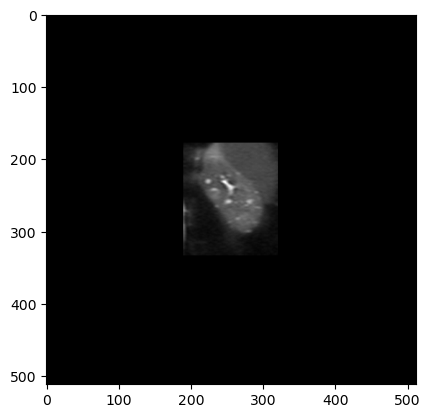

In [16]:
plt.imshow(image_stack[30,:,:,0], cmap='gray')

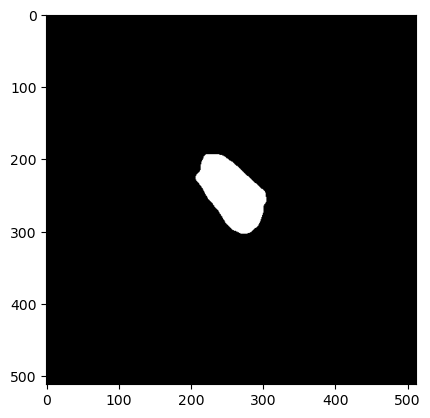

In [17]:
og_seg = np.load(data_path +"\\"+label_list[30])
plt.imshow(og_seg, cmap='gray')

In [30]:
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

In [19]:
img_prediction.shape
segmentation = img_prediction[30,:,:,]
segmentation = segmentation[:,:,1]
segmentation.shape

(512, 512)

In [3]:
def visualise_data_pred(x):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    #contours = measure.find_contours(y[50*i,:,:,0], .99)
    #for contour in contours:
      #ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')
def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

<Figure size 640x480 with 0 Axes>

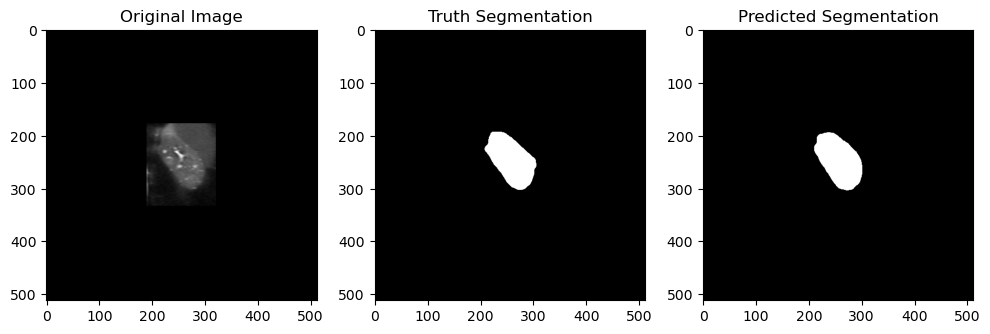

In [20]:
img_prediction_30 = img_prediction[30,:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[30,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

In [25]:
print(len(label_list))
print(len(images))

31
79


## Save the Predictions

In [26]:
path = r"C:\Users\UAB\data\KU\KU-NPY-SmallBatch_testing\train_predictions"
for i in range(len(img_prediction)):
    image_save = img_prediction[i,:,:]
    label = label_list[i][:-5]
    filename = str(label + 'P.npy')
    np.save(os.path.join(path, filename), image_save)
    
    

In [94]:
def visualise_data(x, y):
  n=1
  dim = 10
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

TypeError: tuple indices must be integers or slices, not tuple

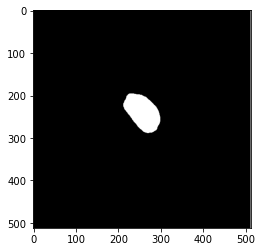

In [97]:
contours = measure.find_contours(segmentation, 0.8)
fig, ax = plt.subplots()
ax.imshow(segmentation, cmap=plt.cm.gray)

for contour in contours:
    #ax.imshow(image_stack[30,:,:,0], cmap="gray")
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=4)

contours = measure.find_contours(og_seg, .8)
for contour in enumerate(contours):
    ax.plot(contour[:,1], contour[:,0], color='#f03ee4', lw=4)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Prediction on UAB Dataset

In [7]:
data_path = r'C:\Users\UAB\data\UAB\AllNPY'
images = gather_images(data_path)

In [8]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [9]:
image_names = images[0:31]
image_stack = np.empty((32,512,512,1))
label_list = []
for i in range(len(image_names)):
    image = np.load(data_path +"\\"+images[i])
    image_stack[i, ...,0] = image[...]
    label_match = str(images[i][:-5] + 'K.npy')
    label_list.append(label_match)

print(image_stack.shape)
print(label_list)

(32, 512, 512, 1)
['407132_0_10_L_0_K.npy', '407132_0_10_L_1_K.npy', '407132_0_10_L_2_K.npy', '407132_0_10_L_3_K.npy', '407132_0_10_L_4_K.npy', '407132_0_10_L_5_K.npy', '407132_0_10_L_6_K.npy', '407132_0_10_L_7_K.npy', '407132_0_10_L_8_K.npy', '407132_0_10_L_9_K.npy', '407132_0_10_R_0_K.npy', '407132_0_10_R_1_K.npy', '407132_0_10_R_2_K.npy', '407132_0_10_R_3_K.npy', '407132_0_10_R_4_K.npy', '407132_0_10_R_5_K.npy', '407132_0_10_R_6_K.npy', '407132_0_10_R_7_K.npy', '407132_0_10_R_8_K.npy', '407132_0_10_R_9_K.npy', '407132_1_10_L_0_K.npy', '407132_1_10_L_1_K.npy', '407132_1_10_L_2_K.npy', '407132_1_10_L_3_K.npy', '407132_1_10_L_4_K.npy', '407132_1_10_L_5_K.npy', '407132_1_10_L_6_K.npy', '407132_1_10_L_7_K.npy', '407132_1_10_L_8_K.npy', '407132_1_10_L_9_K.npy', '407132_1_10_R_0_K.npy']


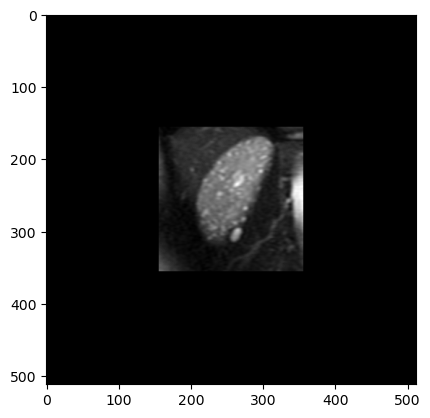

In [14]:
plt.imshow(image_stack[5,:,:,0], cmap='gray')

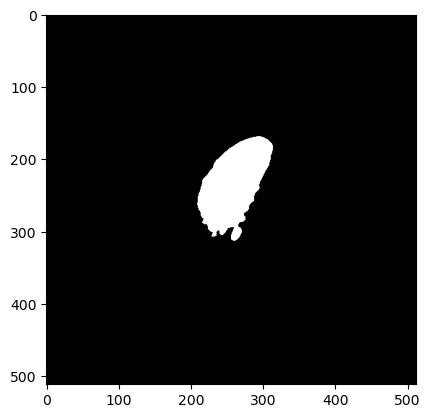

In [16]:
og_seg = np.load(data_path +"\\"+label_list[5])
plt.imshow(og_seg, cmap='gray')

In [17]:
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

In [18]:
img_prediction.shape
segmentation = img_prediction[5,:,:,]
segmentation = segmentation[:,:,1]
segmentation.shape

(512, 512)

<Figure size 640x480 with 0 Axes>

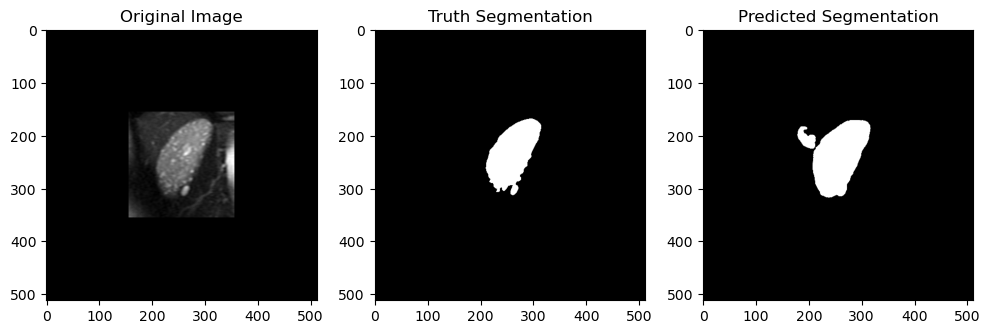

In [19]:
img_prediction_30 = img_prediction[5,:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[5,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

<Figure size 640x480 with 0 Axes>

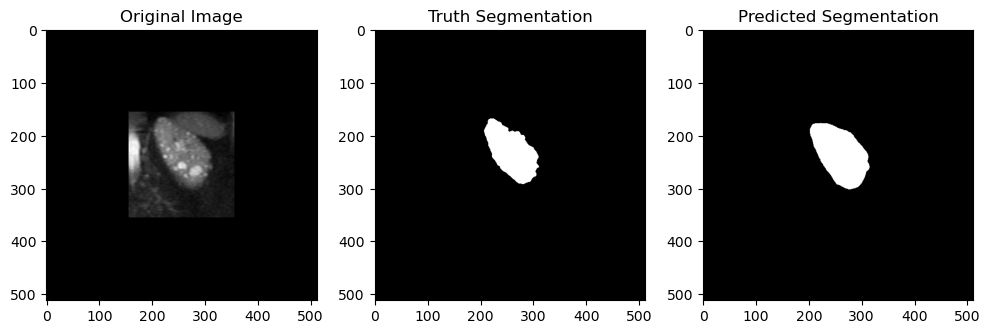

In [22]:
n=16
og_seg = np.load(data_path +"\\"+label_list[n])
segmentation = img_prediction[n,:,:,]
segmentation = segmentation[:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[n,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

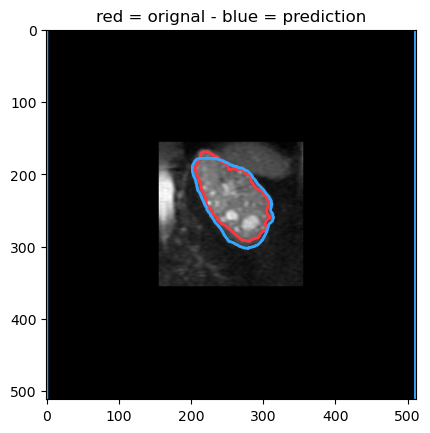

In [40]:

    fig, ax = plt.subplots()
    ax.imshow(image_stack[n,:,:,0], cmap=plt.cm.gray)

    contours = measure.find_contours(og_seg, 0.8)
    for j,contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
        contours = measure.find_contours(segmentation, 0.8)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)

    ax.axis('image')
    ax.title.set_text('red = orignal - blue = prediction')

In [17]:
def visualize_predicition(image_stack, n):
    fig, ax = plt.subplots()
    ax.imshow(image_stack[n,:,:,0], cmap=plt.cm.gray)
    og_seg = np.load(data_path +"\\"+label_list[n])
    segmentation = img_prediction[n,:,:,]
    segmentation = segmentation[:,:,1]

    contours = measure.find_contours(og_seg, 0.8)
    for j,contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
        contours = measure.find_contours(segmentation, 0.8)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)

    ax.axis('image')
    ax.title.set_text('red is orignal - blue is prediction')

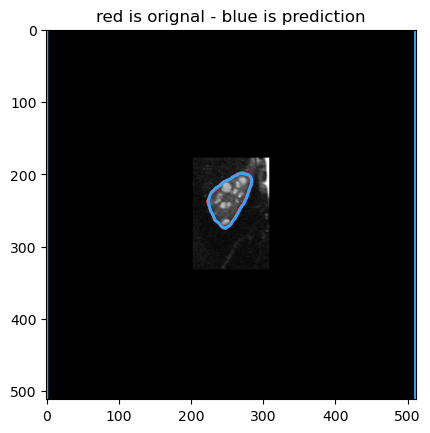

In [22]:
visualize_predicition(image_stack, 15)

# Predict Mayo Data


In [11]:
data_path = r'C:\Users\UAB\data\Mayo\AllNPY'
images = gather_images(data_path)
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [12]:
image_names = images[0:31]
image_stack = np.empty((32,512,512,1))
label_list = []
for i in range(len(image_names)):
    image = np.load(data_path +"\\"+images[i])
    image_stack[i, ...,0] = image[...]
    label_match = str(images[i][:-5] + 'K.npy')
    label_list.append(label_match)

print(image_stack.shape)
print(label_list)

(32, 512, 512, 1)
['300641_0_105_L_0_K.npy', '300641_0_105_L_100_K.npy', '300641_0_105_L_101_K.npy', '300641_0_105_L_102_K.npy', '300641_0_105_L_103_K.npy', '300641_0_105_L_104_K.npy', '300641_0_105_L_10_K.npy', '300641_0_105_L_11_K.npy', '300641_0_105_L_12_K.npy', '300641_0_105_L_13_K.npy', '300641_0_105_L_14_K.npy', '300641_0_105_L_15_K.npy', '300641_0_105_L_16_K.npy', '300641_0_105_L_17_K.npy', '300641_0_105_L_18_K.npy', '300641_0_105_L_19_K.npy', '300641_0_105_L_1_K.npy', '300641_0_105_L_20_K.npy', '300641_0_105_L_21_K.npy', '300641_0_105_L_22_K.npy', '300641_0_105_L_23_K.npy', '300641_0_105_L_24_K.npy', '300641_0_105_L_25_K.npy', '300641_0_105_L_26_K.npy', '300641_0_105_L_27_K.npy', '300641_0_105_L_28_K.npy', '300641_0_105_L_29_K.npy', '300641_0_105_L_2_K.npy', '300641_0_105_L_30_K.npy', '300641_0_105_L_31_K.npy', '300641_0_105_L_32_K.npy']


In [13]:
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

In [ ]:
def save_predictions(image_predictions, label_list):
    for i in range(len(label_list)):
        label_name = label_list[i]
        image = image_predictions[i,:,:]
        new_fname = str(label_list[:-5] + "P.npy")
        np.save(os.path.join(new_path, new_fname), image)

<Figure size 640x480 with 0 Axes>

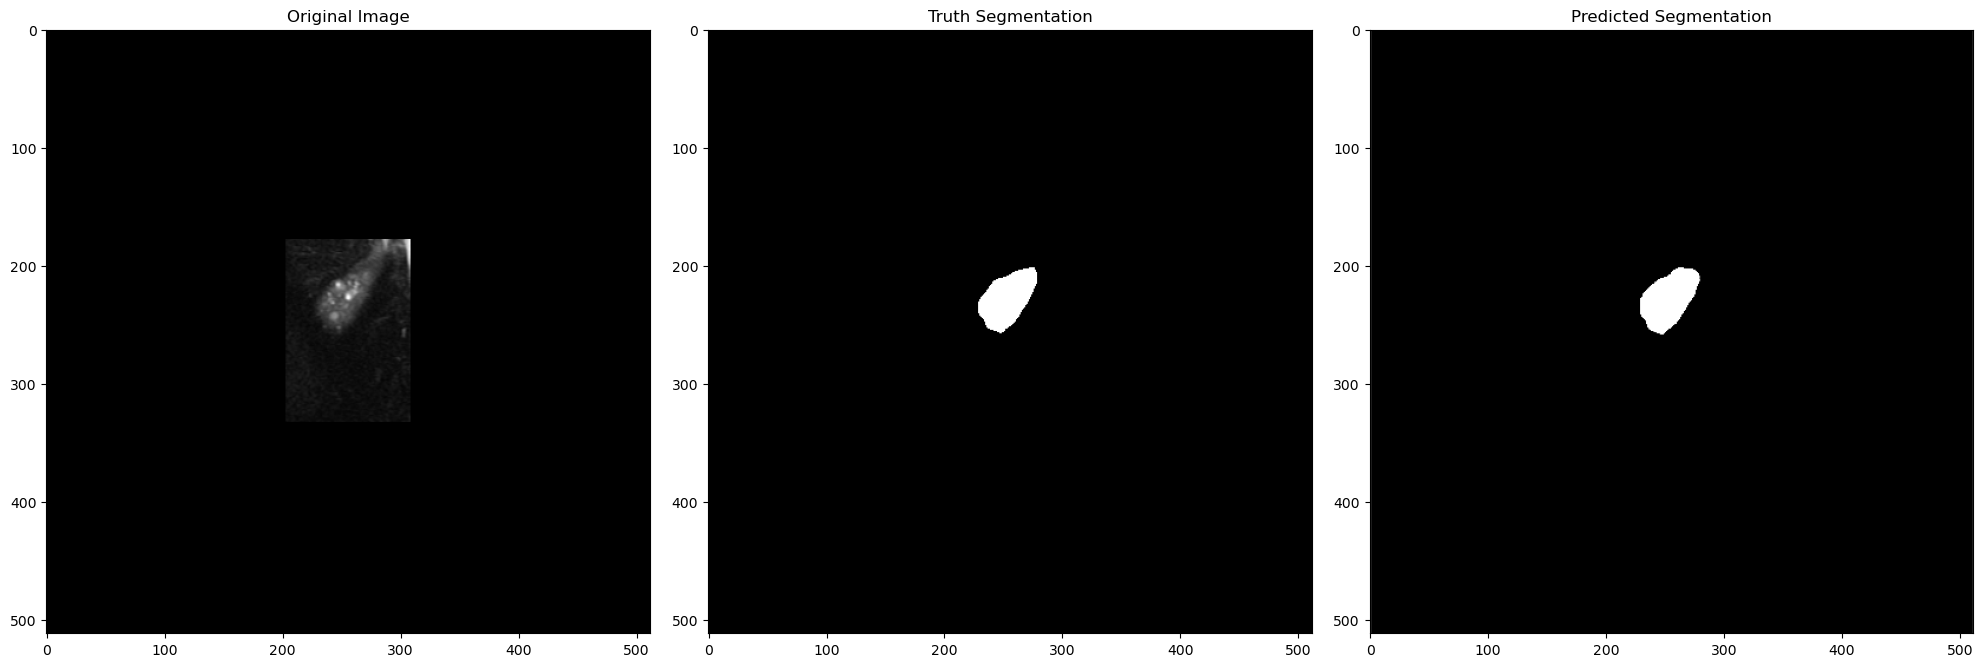

In [16]:
n=10
og_seg = np.load(data_path +"\\"+label_list[n])
segmentation = img_prediction[n,:,:,]
segmentation = segmentation[:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(20,20))
f.tight_layout()

axarr[0].imshow(image_stack[n,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

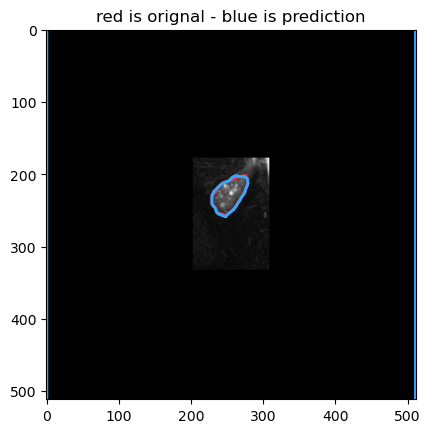

In [23]:
visualize_predicition(image_stack, 10)

<Figure size 640x480 with 0 Axes>

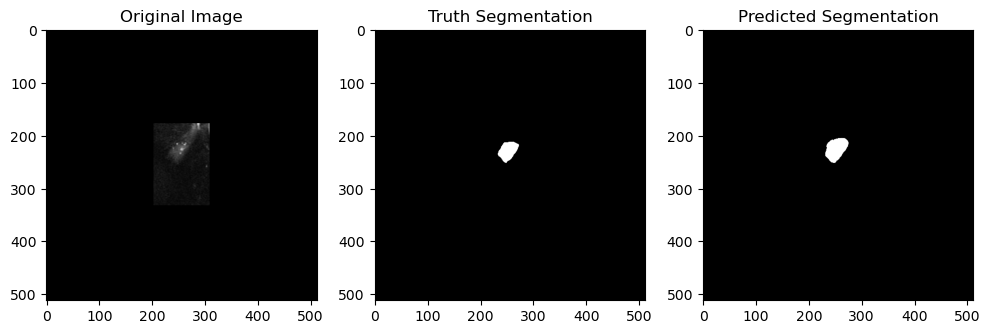

In [30]:
n=7
og_seg = np.load(data_path +"\\"+label_list[n])
segmentation = img_prediction[n,:,:,]
segmentation = segmentation[:,:,1]
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image_stack[n,:,:,0], cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(og_seg, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(segmentation, cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

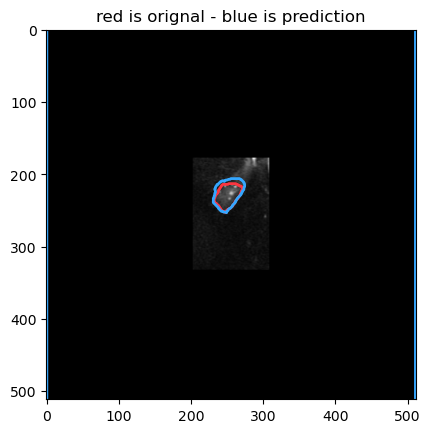

In [29]:
visualize_predicition(image_stack, 7)